# **Google drive loading**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive




$\color{red}{\text{WARNING:}}$ remember to set GPU in the Notebook settings:


```
Runtime > Change runtime type > GPU
```




# Import's and Data

**Data in one folder**:
If we have one folder that containes all the images, a strategy could be to add a function that directly extrapolates and puts them in a tensor

In [ ]:
# Let's start by importing the required libraries 
# Importing from keras or from tensorflow.keras is equivalent for tf.version > 2
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras.utils import load_img
from keras.utils import img_to_array
from keras.utils import Sequence as Sequence
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import random_rotation, random_shear, random_shift

In [ ]:
def preprocess(path, img_rows, img_cols):
  imgs_array = []
  label_array = []

  for file_name in os.listdir(path):
    img = load_img(os.path.join(path, file_name), 
                  target_size = (img_rows, img_cols))

    # If the image's name starts with "cat" then the label will be 0, otherwise 1
    if file_name.startswith('cat'): 
      label_array.append(0)
      x = img_to_array(img)
      # Apply the same preprocessing that was used when VGG16 was trained
      x = preprocess_input(x) 
      # Images are added to a list
      imgs_array.append(x)
    else: 
      label_array.append(1)
      x = img_to_array(img)
      x = preprocess_input(x)
      imgs_array.append(x)

  # Data are converted to an array
  imgs_array = np.asarray(imgs_array) 
  label_array = np.asarray(label_array)
  
  return imgs_array, label_array

In [ ]:
# Path to my dataset: EDIT IT WITH YOUR OWN PATH to the folder dog_and_cat  
path = "/content/gdrive/MyDrive/2023-CV&DL/Classificazione/dog_and_cat/"

# Image size
immg_rows = 224
immg_cols = 224   

# Preprocessing and shuffle
# Random state allows to obtain the same shuffle over time

new_array, new_label = preprocess(path, immg_rows, immg_cols)
new_array, new_label = shuffle(new_array, new_label, random_state=24) 

images shape: (1033, 224, 224, 3)
labels shape: (1033,)


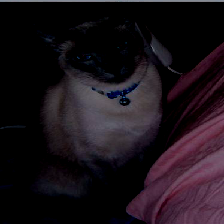

WHICH LABEL?  0


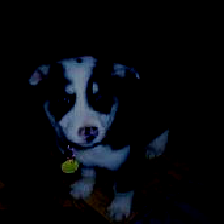

WHICH LABEL?  1


In [ ]:
# Let's see if we are doing well
from google.colab.patches import cv2_imshow
print("images shape:", new_array.shape)
print("labels shape:", new_label.shape)
cv2_imshow(new_array[3,:,:,:])
print("WHICH LABEL? ", new_label[3])
cv2_imshow(new_array[2,:,:,:])
print("WHICH LABEL? ", new_label[2])

#Hold-out: Train/Validation/Test Split

**Hold-out** is when you split up your dataset into a ‘train’, validation’, and ‘test’ sets. The training set is what the model is trained on, and the test set is used to see how well that model performs on unseen data.
![alt text](https://drive.google.com/uc?id=1L0na_K4l6Fk3s9KjMMzy7RHjAajrydJU)

In [ ]:
from sklearn.model_selection import train_test_split

# Split in dataset in train-test
Xtrain, X_test, ytrain, y_test = train_test_split(new_array,new_label, test_size=0.30, stratify=new_label, random_state=42)

# Split train in train-valid
X_train, X_valid, y_train, y_valid = train_test_split(Xtrain, ytrain, test_size=0.20, stratify=ytrain, random_state=42)

# Data Augmentation (offline)

**Offline data augmentation**: Image data augmentation is a technique that can be used to artificially expand the size of a training dataset by creating modified versions of images in the dataset. Usually the augmentation is performed on the training set only.


![alt text](https://cdn-images-1.medium.com/max/1000/1*C8hNiOqur4OJyEZmC7OnzQ.png)

This approach is usefull when the dataset is very poor BUT we are not exactly increasing the ability of our model to generalize. To do that, we should implement 
**on-the-fly data augmentation** (as opposed to the here proposed offline data augmentation).

In [ ]:
# This is just an example of data augmentation: there are so many functions that you can use!

from keras.preprocessing.image import random_shift as rand_shift
from keras.preprocessing.image import random_rotation as rand_rotation


def flip_axis(x, axis=1):
  cp = np.copy(x)
  cp = np.asarray(cp).swapaxes(axis, 0)
  cp = cp[::-1, ...]
  cp = cp.swapaxes(0, axis)
  return cp


def augment_data(images, labels, augementation_factor=1, do_flip_axis=False,
                 do_rand_rotation=False, do_rand_shift=False):

  augmented_image = []
  augmented_labels = []
  for id, img in enumerate(images):
    # original image:
    augmented_image.append(img)
    augmented_labels.append(labels[id])
      
    for i in range(augementation_factor):
      # flipping
      if do_flip_axis:
        augmented_image.append(flip_axis(img))
        augmented_labels.append(labels[id])
      # Random rotation
      if do_rand_rotation:
        augmented_image.append(rand_rotation(img, 60, row_axis=0, 
                        col_axis=1, channel_axis=2, fill_mode='constant'))
        augmented_labels.append(labels[id])
      # Random spatial shift
      if do_rand_shift:
        augmented_image.append(rand_shift(img, 0.2, 0.2, row_axis=0,
                          col_axis=1, channel_axis=2, fill_mode='constant'))
        augmented_labels.append(labels[id])

  augmented_image = shuffle(augmented_image, random_state=24)
  augmented_labels = shuffle(augmented_labels, random_state=24)
  return np.array(augmented_image), np.array(augmented_labels)

In [ ]:
# Apply data augmentation
# In this case we only flipped the images. If we wanna apply the other functions, just change the False with True

X_train_augm, y_train_augm = augment_data(X_train, y_train, do_rand_rotation=True, do_flip_axis=True)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_train_augm.shape)
print(y_train_augm.shape)
print(f"we have {X_train_augm.shape[0]//X_train.shape[0]} times more images")

(578, 224, 224, 3)
(578,)
(1734, 224, 224, 3)
(1734,)
we have 3 times more images


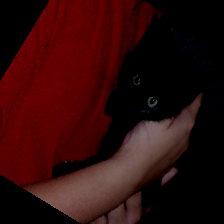

WHICH LABEL?  0


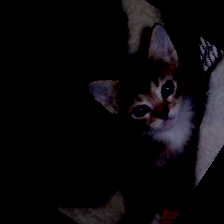

WHICH LABEL?  0


In [ ]:
cv2_imshow(X_train_augm[89,:,:,:])
print("WHICH LABEL? ",y_train_augm[89])
cv2_imshow(X_train_augm[700,:,:,:])
print("WHICH LABEL? ",y_train_augm[700])

# Fine tuning

## Define the model

The task of fine-tuning a network is to *tweak* the parameters of an already trained network so that it adapts to the new task. The initial layers learn very general features, whereas, as we delve into the network, the layers tend to learn patterns that are more specific to that specific task. Thus, to fine-tune a pre-trained network, we want to *freeze* the initial layers (i.e., they cannot be trained anymore) and re-train the deepest (or final) layers on the new task.

**Our case**: We load the weights of VGG16 pre-trained on Imagenet, we freeze every layer but the last four (top layers), which will be re-trained from that initial state.

![alt text](https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png)

In [ ]:
# First, we will load a VGG model without the top layers (the fully connected ones)
from keras.applications.vgg16 import VGG16
from keras import models
from keras import layers, Sequential
from keras import optimizers

vgg_conv = VGG16(weights = 'imagenet', include_top = False, input_shape = (immg_rows, immg_cols, 3))

# Freeze the layers except the last 4 layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

58889256/58889256 [==============================] - 2s 0us/step
<keras.engine.input_layer.InputLayer object at 0x7f64ca1563a0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f6474d1cfa0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f64af94e1f0> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f64af9221f0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f64af94e700> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f64ac2bc820> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f64ac2e6310> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f64ac2bcc40> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f64ac2f1100> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f64ac2f1880> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f64ac276640> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f64ac2eb610> False
<keras.layers.convolutional.con

In [ ]:
model = Sequential() #A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.
model.add(vgg_conv)
          
# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1024)              25691136  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 2)                 1

## Train the model

In [ ]:
# Create a directory where the model weights will be saved 
path_ = path[:path.find("dog_and_cat")]
print("This is a directory", path_)
os.mkdir(os.path.join(path_, "results_"))
res_dir = os.path.join(path_, "results_")

This is a directory /content/gdrive/MyDrive/2023-CV&DL/Classificazione/


In [ ]:
from keras.utils.np_utils import to_categorical

print(to_categorical(y_valid))
print(to_categorical(y_train_augm))

[[1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 

In [ ]:
from keras.callbacks import ModelCheckpoint

num_epochs = 20

# Converts a class vector (integers) to binary class matrix-->this because we have 2 neurons at the end
y_train_augm = to_categorical(y_train_augm, num_classes=2) 
y_valid = to_categorical(y_valid, num_classes=2)


checkpoint = ModelCheckpoint(os.path.join(res_dir, "model.h5"),
                             verbose=1, monitor='val_loss', save_best_only=True)
model.compile(loss="categorical_crossentropy", metrics="Recall", 
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9)) 

history = model.fit(X_train_augm, y_train_augm, epochs=num_epochs, batch_size=32, validation_data=(X_valid, y_valid), verbose=1, callbacks=[checkpoint])

Epoch 1/20
55/55 [==============================] - ETA: 0s - loss: 1.7266 - recall: 0.8651
Epoch 1: val_loss improved from inf to 0.19383, saving model to /content/gdrive/MyDrive/2023-CV&DL/Classificazione/results_/model.h5
55/55 [==============================] - 28s 254ms/step - loss: 1.7266 - recall: 0.8651 - val_loss: 0.1938 - val_recall: 0.9793
Epoch 2/20
55/55 [==============================] - ETA: 0s - loss: 0.1157 - recall: 0.9706
Epoch 2: val_loss did not improve from 0.19383
55/55 [==============================] - 9s 166ms/step - loss: 0.1157 - recall: 0.9706 - val_loss: 0.2765 - val_recall: 0.9586
Epoch 3/20
55/55 [==============================] - ETA: 0s - loss: 0.0723 - recall: 0.9764
Epoch 3: val_loss did not improve from 0.19383
55/55 [==============================] - 9s 165ms/step - loss: 0.0723 - recall: 0.9764 - val_loss: 0.2615 - val_recall: 0.9793
Epoch 4/20
55/55 [==============================] - ETA: 0s - loss: 0.0508 - recall: 0.9839
Epoch 4: val_loss impro

In [ ]:
# Save weights and history
import pandas as pd

history_ = pd.DataFrame(history.history)
with open(os.path.join(path_, "results_", "history.json"), "w") as json_file:
    history_.to_json(json_file)

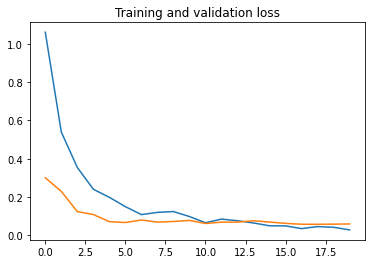

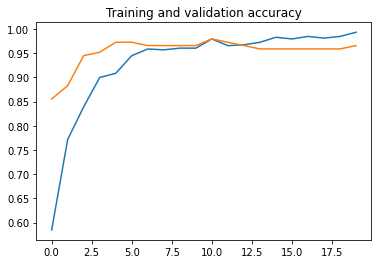

In [ ]:
import matplotlib.pyplot as plt

epochs = num_epochs
plt.figure()
plt.title('Training and validation loss')
plt.plot(np.arange(0, epochs), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), history.history["val_loss"], label="val_loss")

plt.figure()
plt.title('Training and validation accuracy')
plt.plot(np.arange(0, epochs), history.history["recall"], label="train_rec")
plt.plot(np.arange(0, epochs), history.history["val_rec"], label="val_rec")

# Test the model

In [ ]:
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
y_pred_max = np.argmax(y_pred, 1)

print(sklearn.metrics.classification_report(y_test, y_pred_max))
print("accuracy:",accuracy_score(y_test, y_pred_max))

10/10 [==============================] - 4s 391ms/step
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       155
           1       0.99      0.97      0.98       155

    accuracy                           0.98       310
   macro avg       0.98      0.98      0.98       310
weighted avg       0.98      0.98      0.98       310

accuracy: 0.9806451612903225


In [ ]:
test_loss, test_acc = model.evaluate(X_test, to_categorical(y_test, num_classes = 2))

10/10 [==============================] - 1s 134ms/step - loss: 0.0431 - accuracy: 0.9839


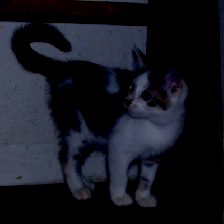

final activations: [9.9997199e-01 2.7999193e-05]. it's a cat


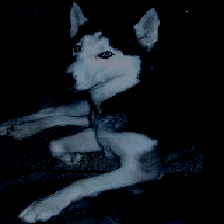

final activations: [0.10950413 0.89049584]. it's a dog


In [ ]:
cv2_imshow(X_test[0,:,:,:])
print(f"final activations: {y_pred[0]}. it's a {'cat' if y_pred_max[0] == 0 else 'dog'}")
cv2_imshow(X_test[4,:,:,:])
print(f"final activations: {y_pred[4]}. it's a {'cat' if y_pred_max[4] == 0 else 'dog'}")

## Performance visualization

### ROC Curve

In [ ]:
from sklearn.metrics import roc_curve, auc

n_classes = 2
gt = to_categorical(y_test, n_classes)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(gt[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(gt.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

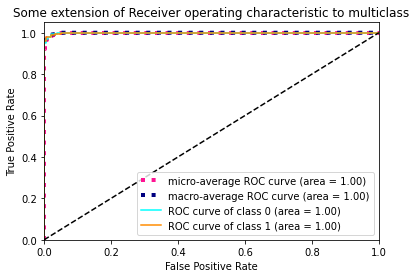

In [ ]:
from itertools import cycle

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

### Confusion matrix

<Axes: >

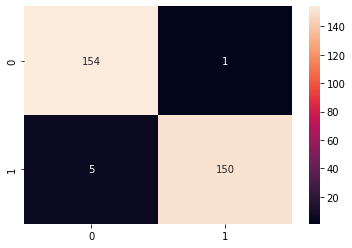

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf = confusion_matrix(y_test, y_pred_max)
sns.heatmap(conf, annot=True, fmt="d")

<Axes: >

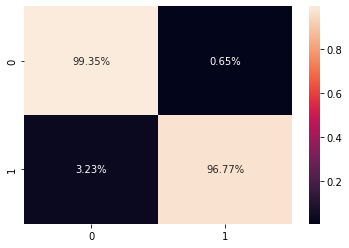

In [ ]:
cm = conf.astype('float') / conf.sum(axis=1)
sns.heatmap(cm, annot=True, fmt='.2%')